# Решение задачи оптимизации логистики

In [1]:
import misc
import numpy as np
from tqdm.notebook import trange
from matplotlib import pyplot as plt

In [2]:
data = misc.open_data()
print()
print(f"Количество открытых файлов: {len(data)}")

Parse Error on file:
data\E\E-n101-k14.vrp
Parse Error on file:
data\E\E-n101-k8.vrp
Parse Error on file:
data\E\E-n13-k4.vrp
Parse Error on file:
data\E\E-n31-k7.vrp
Parse Error on file:
data\E\E-n76-k8.vrp
Parse Error on file:
data\P\P-n51-k10.vrp

Количество открытых файлов: 60


In [3]:
for key in data[0]:
    print(f"{key}:", data[0][key])

optimal_value: 672
dimension: 31
capacity: 100
nodes: [(17, 76), (24, 6), (96, 29), (14, 19), (14, 32), (0, 34), (16, 22), (20, 26), (22, 28), (17, 23), (98, 30), (30, 8), (23, 27), (19, 23), (34, 7), (31, 7), (0, 37), (19, 23), (0, 36), (26, 7), (98, 32), (5, 40), (17, 26), (21, 26), (28, 8), (1, 35), (27, 28), (99, 30), (26, 28), (17, 29), (20, 26)]
demand: [0, 25, 3, 13, 17, 16, 9, 22, 10, 16, 8, 3, 16, 16, 10, 24, 16, 15, 14, 5, 12, 2, 18, 20, 15, 8, 22, 15, 10, 13, 19]


In [4]:
class Logistics:
    def __init__(self):
        self.optimal_value = None
        self.capacity = None
        self.dots_list = None
        self.demand_list = None
        self.path_list = None


    def _calculate_path_demand(self, path):
        """Подсчет пути по грузоподъемности
        """
        path_length = 0
        for i in path:
            path_length += self.demand_list[i]
        return path_length


    def _linear_path_init(self):
        """Инициализация путей по порядку заказов
        """
        path_list = []

        cur_demand = 0
        cur_path = []

        for i in range(1, len(self.dots_list)):
            new_demand = self.demand_list[i]
            if new_demand > self.capacity:
                print("Demand error!")
                raise Exception

            cur_demand += new_demand
            if cur_demand > self.capacity:
                path_list.append(np.array(cur_path))
                cur_path = [i]
                cur_demand = new_demand
            else:
                cur_path.append(i)

        path_list.append(np.array(cur_path))
        return path_list


    def fit(self, data):
        """Инициализация данных
        """
        self.optimal_value = data["optimal_value"]
        self.capacity = data["capacity"]
        self.dots_list = np.array(data["nodes"])
        self.demand_list = np.array(data["demand"])
        self.path_list = self._linear_path_init()


    def optimize(self, N_iter=1000, theta=100, alpha=0.999, disable_tqdm=False):
        """Оптимизация маршрута
        """
        theta = theta

        for _ in trange(N_iter, disable=disable_tqdm):
            while True:
                path_idx = np.random.randint(0, len(self.path_list), 2)
                path_0 = self.path_list[path_idx[0]]
                path_1 = self.path_list[path_idx[1]]
                if path_idx[0] != path_idx[1]:
                    break

            prev_length = self._calculate_path_length(path_0) + \
                self._calculate_path_length(path_1)

            idx_0 = np.random.randint(0, len(path_0))
            idx_1 = np.random.randint(0, len(path_1))

            new_path_0 = np.concat([path_0[:idx_0], [path_1[idx_1]], path_0[idx_0 + 1:]], dtype=np.int32)
            new_path_1 = np.concat([path_1[:idx_1], [path_0[idx_0]], path_1[idx_1 + 1:]], dtype=np.int32)

            if self._calculate_path_demand(new_path_0) > self.capacity or \
                self._calculate_path_demand(new_path_1) > self.capacity:
                continue

            new_length = self._calculate_path_length(new_path_0) + \
                self._calculate_path_length(new_path_1)

            if new_length < prev_length:
                probability = 1
            else:
                theta *= alpha
                probability = np.exp(-(new_length - prev_length) / theta)

            if np.random.random() > probability:
                continue

            self.path_list[path_idx[0]] = new_path_0
            self.path_list[path_idx[1]] = new_path_1


    def _euc_distance(self, dot1, dot2):
        """Подсчет расстояния между двумя точками
        """
        dist = np.sqrt(np.sum((dot1 - dot2) ** 2))
        return dist


    def _calculate_path_length(self, path):
        """Подсчет пройденного растояния по точкам
        """
        path_length = 0

        dots_list = self._get_dots_by_path(path)
        prev = dots_list[0]

        for dot in dots_list:
            path_length += self._euc_distance(prev, dot)
            prev = dot

        return path_length


    def _get_dots_by_path(self, path):
        """Получить точки по маршруту, включая точки отправки и возвращения
        """
        dots = self.dots_list[path]
        dots = np.concat([[self.dots_list[0]], dots, [self.dots_list[0]]], dtype=np.int32)
        return dots


    def plot_paths(self):
        """Построение графика с маршрутами
        """
        for path in self.path_list:
            dots = self._get_dots_by_path(path)
            x = dots[:, 0]
            y = dots[:, 1]
            plt.plot(x, y)
        plt.show()

Путь №0:
    Расстояние пути: 329.69
    Вес пути: 83.00
Путь №1:
    Расстояние пути: 291.70
    Вес пути: 91.00
Путь №2:
    Расстояние пути: 410.28
    Вес пути: 98.00
Путь №3:
    Расстояние пути: 304.47
    Вес пути: 98.00
Путь №4:
    Расстояние пути: 112.22
    Вес пути: 42.00
Количество путей: 5
Общий путь: 1448.37
Отклонение: 115.53%


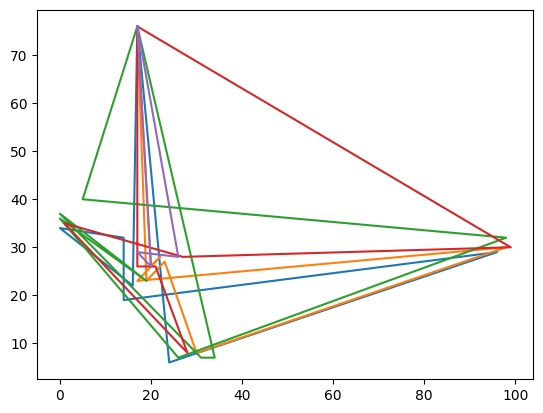

In [5]:
logistic = Logistics()
logistic.fit(data[0])

total_length = 0
number = 0

for path in logistic.path_list:
    path_length = logistic._calculate_path_length(path)
    path_demand = logistic._calculate_path_demand(path)

    print(f"Путь №{number}:")
    print(f"    Расстояние пути: {path_length:.2f}")
    print(f"    Вес пути: {path_demand:.2f}")

    total_length += path_length
    number += 1

deviation = (total_length - logistic.optimal_value) / logistic.optimal_value

print(f"Количество путей: {number}")
print(f"Общий путь: {total_length:.2f}")
print(f"Отклонение: {deviation * 100:.2f}%")

logistic.plot_paths()

  0%|          | 0/40000 [00:00<?, ?it/s]

Путь №0:
    Расстояние пути: 168.66
    Вес пути: 87
Путь №1:
    Расстояние пути: 108.63
    Вес пути: 98
Путь №2:
    Расстояние пути: 190.43
    Вес пути: 98
Путь №3:
    Расстояние пути: 117.62
    Вес пути: 99
Путь №4:
    Расстояние пути: 113.01
    Вес пути: 96
Путь №5:
    Расстояние пути: 72.97
    Вес пути: 51
Путь №6:
    Расстояние пути: 94.26
    Вес пути: 80
Количество путей: 7
Общий путь: 865.58
Отклонение: 16.81%


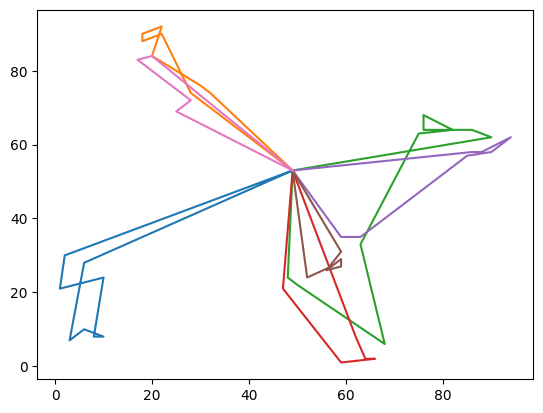

In [82]:
np.random.seed(1)

logistic.fit(data[10])
logistic.optimize(40_000, 1000, 0.9995)

total_length = 0
number = 0

for path in logistic.path_list:
    path_length = logistic._calculate_path_length(path)
    path_demand = logistic._calculate_path_demand(path)

    print(f"Путь №{number}:")
    print(f"    Расстояние пути: {path_length:.2f}")
    print(f"    Вес пути: {path_demand}")

    total_length += path_length
    number += 1

deviation = (total_length - logistic.optimal_value) / logistic.optimal_value

print(f"Количество путей: {number}")
print(f"Общий путь: {total_length:.2f}")
print(f"Отклонение: {deviation * 100:.2f}%")

logistic.plot_paths()

  0%|          | 0/60 [00:00<?, ?it/s]

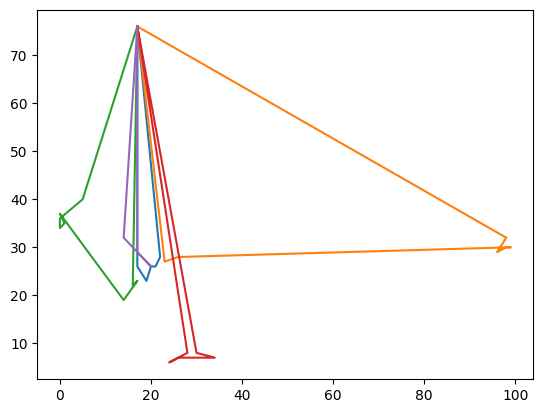

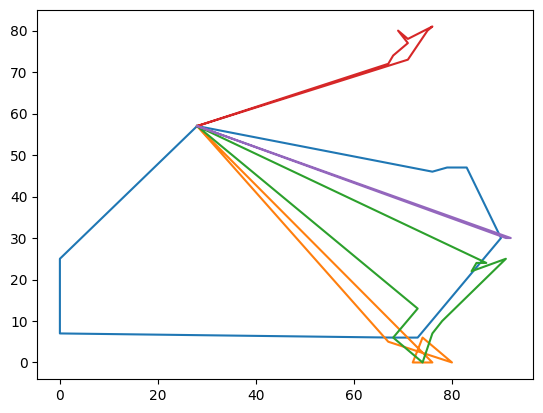

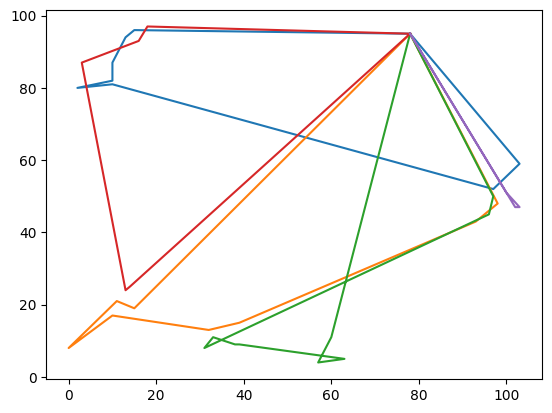

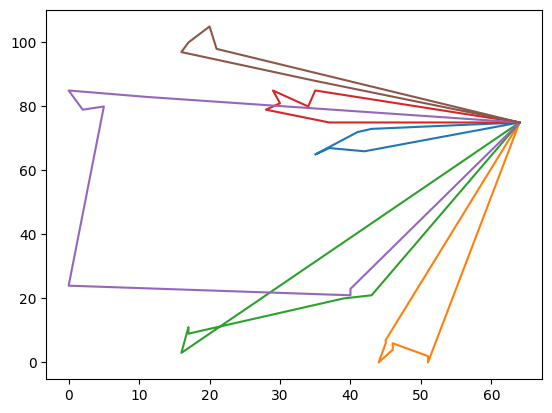

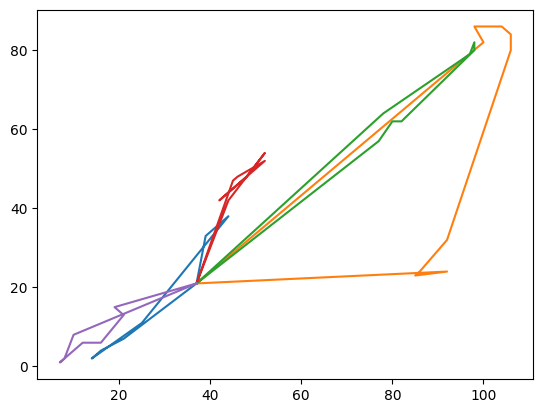

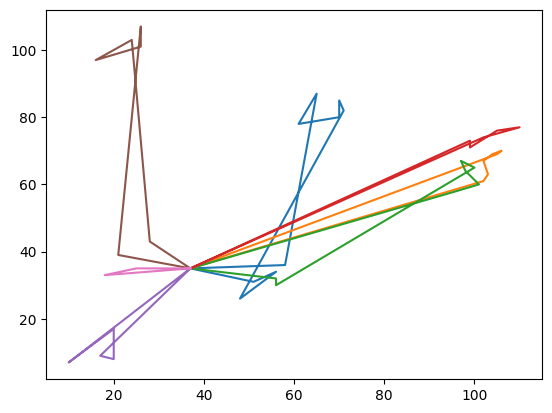

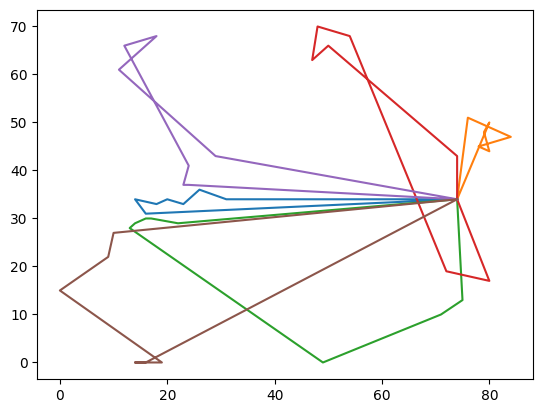

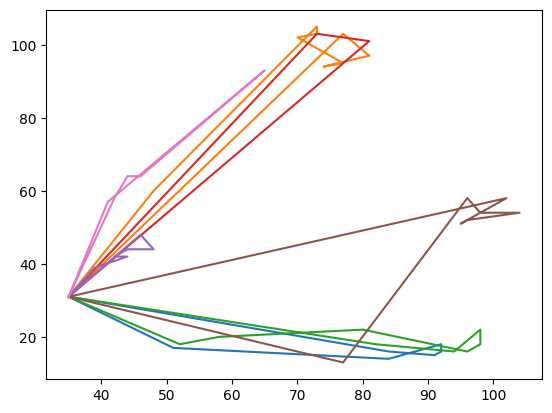

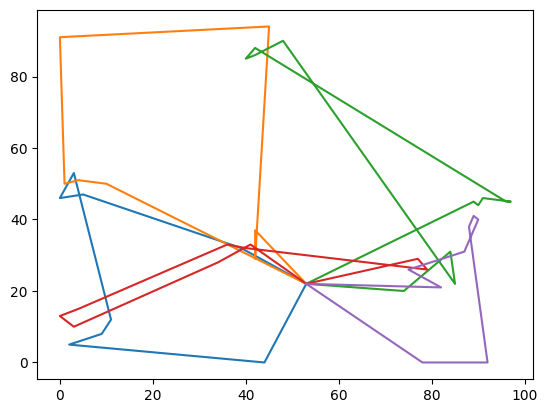

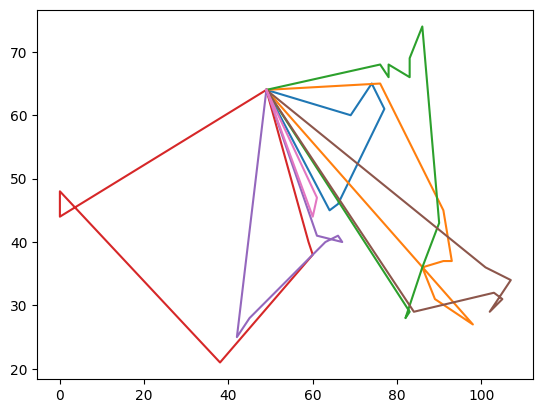

Среднее отклонение: 20.65%


In [81]:
np.random.seed(1)

deviation_list = []
data_trange = trange(len(data))

for i in data_trange:
    logistic.fit(data[i])
    logistic.optimize(100_000, 60, 0.9999, disable_tqdm=True)

    total_length = 0
    number = 0

    for path in logistic.path_list:
        path_length = logistic._calculate_path_length(path)

        total_length += path_length
        number += 1

    deviation = (total_length - logistic.optimal_value) / logistic.optimal_value
    deviation_list.append(deviation)

    message = f"Текущее отклонение: {np.mean(deviation_list) * 100:.2f}%"
    data_trange.set_description(message)

    if i == 0:
        logistic.plot_paths()
print(f"Среднее отклонение: {np.mean(deviation_list) * 100:.2f}%")